#1. Loading packages and dataset

In [ ]:
!pip install optuna
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.4 MB/s eta 0:00:00


In [ ]:
import os
import gc
import time
import warnings
from warnings import simplefilter
from itertools import combinations
import polars as pl
from optuna.samplers import TPESampler
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

from lightgbm import LGBMRegressor,plot_tree
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import optuna
import sklearn as sk
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import train_test_split,StratifiedKFold, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from numba import njit, prange
from catboost import CatBoostRegressor, EShapCalcType, EFeaturesSelectionAlgorithm
from itertools import combinations

In [ ]:
#Loading the training and testing Datasets.
df_train_origin = pd.read_csv('/content/train.csv')
df_train = df_train_origin.sample(200000, random_state = 42)
#df_score = pd.read_csv('/content/test.csv')

In [ ]:
# Set up parameters
#is_offline = False    # Flag for online/offline mode
#is_train = True    # Flag for training mode
#is_infer = True    # Flag for inference mode
#split_day = 435    # Split day for time series data

# 2. EDA

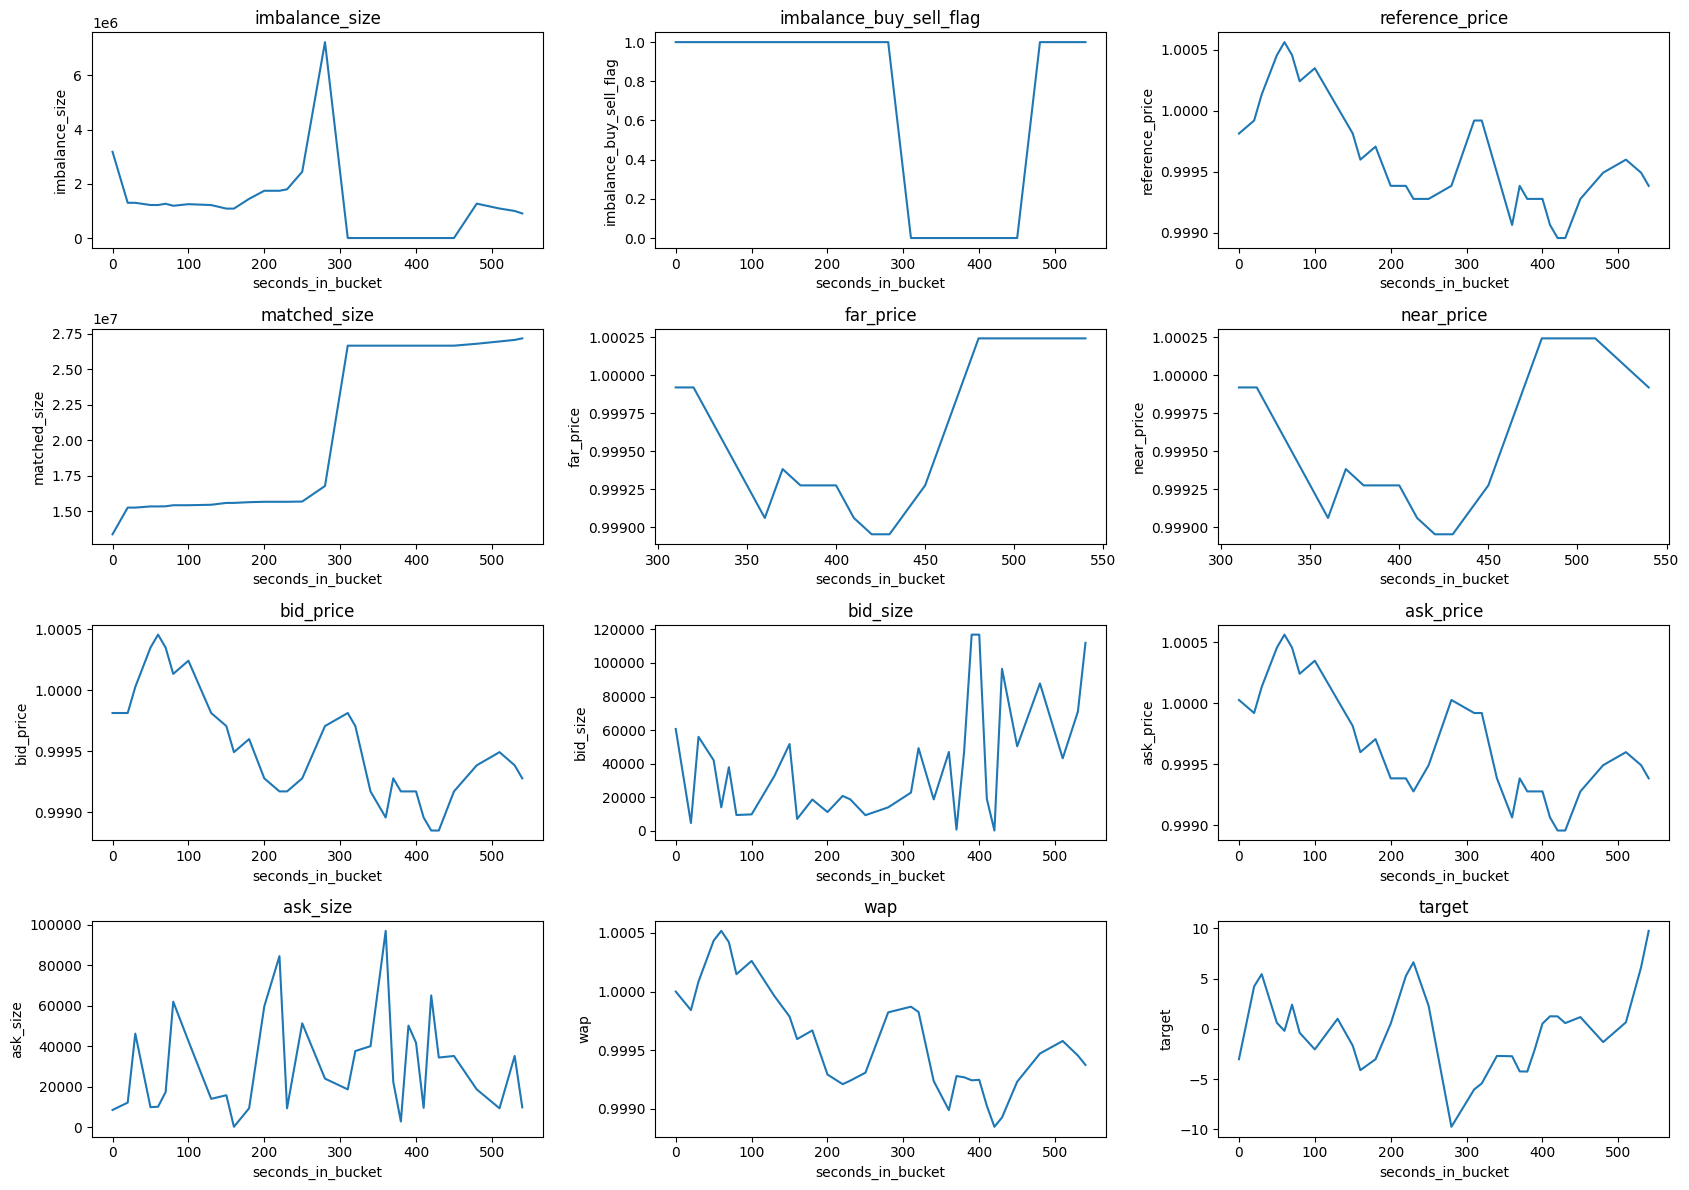

In [ ]:
cols_to_plot = ['imbalance_size','imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price','ask_size', 'wap', 'target']
fig, axes = plt.subplots(4, 3, figsize = (17, 12))
_ = df_train.query("stock_id == 0 & date_id == 0")
for i, col in enumerate(cols_to_plot):
    ax = axes[i // 3, i % 3 ]
    sns.lineplot(data = _, x = 'seconds_in_bucket', y = col, ax = ax)
    ax.set_title(f"{col}")
plt.tight_layout()
plt.show()

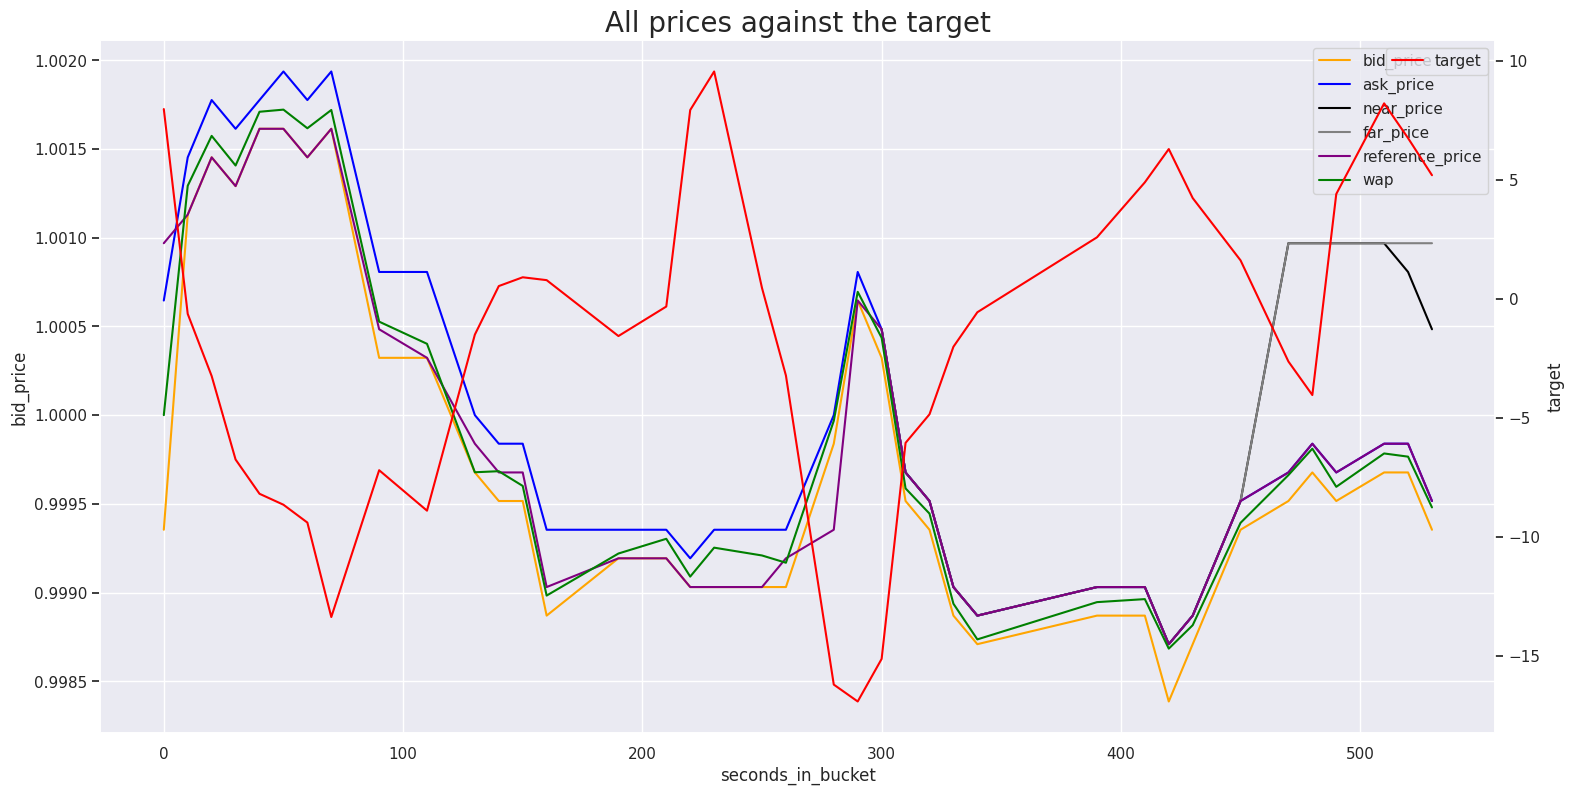

In [ ]:
sns.set(rc = {'figure.figsize': (18,9)})
_ = df_train.query("stock_id == 9 & date_id == 0").assign(bid_ask_spread = lambda df_train : df_train.ask_price - df_train.bid_price)
for col, color in zip(['bid_price', 'ask_price', 'near_price', 'far_price', 'reference_price', 'wap'], ['orange', 'blue','black', 'gray', 'purple', 'green']):
    sns.lineplot(data = _, x = 'seconds_in_bucket', y = col, color = color, label = col)
ax2 = plt.twinx()
ax2.grid(False)
sns.lineplot(data = _, x = 'seconds_in_bucket', y = 'target', color = 'red', label = 'target', ax = ax2)
plt.title("All prices against the target",fontdict={'size':20})
plt.legend()

In [ ]:
corr = _.corr()
corr.style.background_gradient(cmap='coolwarm')

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,bid_ask_spread
stock_id,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
date_id,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
seconds_in_bucket,nan,nan,1.000000,-0.784569,0.846462,-0.637386,0.897932,0.606272,0.568233,-0.605080,0.709487,-0.692569,0.368454,-0.632420,0.366416,1.000000,-0.539575
imbalance_size,nan,nan,-0.784569,1.000000,-0.774157,0.444467,-0.957382,0.894541,0.874577,0.416353,-0.402439,0.503421,-0.160142,0.441818,-0.021499,-0.784569,0.503625
imbalance_buy_sell_flag,nan,nan,0.846462,-0.774157,1.000000,-0.282239,0.893207,0.898726,0.879842,-0.253212,0.642836,-0.336374,0.248013,-0.272449,0.037020,0.846462,-0.455093
reference_price,nan,nan,-0.637386,0.444467,-0.282239,1.000000,-0.442871,0.808334,0.829946,0.955525,-0.273796,0.983706,-0.255517,0.974539,-0.519676,-0.637386,0.310357
matched_size,nan,nan,0.897932,-0.957382,0.893207,-0.442871,1.000000,0.733979,0.678607,-0.429605,0.571235,-0.517917,0.254120,-0.454004,0.128201,0.897932,-0.512129
far_price,nan,nan,0.606272,0.894541,0.898726,0.808334,0.733979,1.000000,0.991773,0.806569,0.493661,0.808334,0.160093,0.823064,-0.037264,0.606272,-0.334107
near_price,nan,nan,0.568233,0.874577,0.879842,0.829946,0.678607,0.991773,1.000000,0.827728,0.445619,0.829946,0.142960,0.843453,-0.078234,0.568233,-0.338061
bid_price,nan,nan,-0.605080,0.416353,-0.253212,0.955525,-0.429605,0.806569,0.827728,1.000000,-0.276919,0.979302,-0.244418,0.993973,-0.627353,-0.605080,0.077576


#3. Pre-processing and Feature Enginnering

In [ ]:
def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:

                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)
    if verbose:
        logger.info(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        logger.info(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        logger.info(f"Decreased by {decrease:.2f}%")
    return df

In [ ]:
# Parallel Triplet Imbalance Calculation
@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))
    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val

            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features

def calculate_triplet_imbalance_numba(price, df):
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]
    features_array = compute_triplet_imbalance(df_values, comb_indices)
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)
    return features

In [ ]:
weights = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]
weights = {int(k):v for k,v in enumerate(weights)}

In [ ]:
def imbalance_features(df):
    # Define lists of price and size-related column names
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]

    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
    df["size_imbalance"] = df.eval("bid_size / ask_size")

    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")

    for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values

    df["stock_weights"] = df["stock_id"].map(weights)
    df["weighted_wap"] = df["stock_weights"] * df["wap"]
    df['wap_momentum'] = df.groupby('stock_id')['weighted_wap'].pct_change(periods=6)

    df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff()
    df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])

    df['spread_depth_ratio'] = (df['ask_price'] - df['bid_price']) / (df['bid_size'] + df['ask_size'])
    df['mid_price_movement'] = df['mid_price'].diff(periods=5).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

    df['micro_price'] = ((df['bid_price'] * df['ask_size']) + (df['ask_price'] * df['bid_size'])) / (df['bid_size'] + df['ask_size'])
    df['relative_spread'] = (df['ask_price'] - df['bid_price']) / df['wap']

    # Calculate various statistical aggregation features
    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)


    for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
        for window in [1,3,5,10]:
            df[f"{col}_shift_{window}"] = df.groupby('stock_id')[col].shift(window)
            df[f"{col}_ret_{window}"] = df.groupby('stock_id')[col].pct_change(window)

    # Calculate diff features for specific columns
    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size', 'weighted_wap','price_spread']:
        for window in [1,3,5,10]:
            df[f"{col}_diff_{window}"] = df.groupby("stock_id")[col].diff(window)

    #V4 feature
    for window in [3,5,10]:
        df[f'price_change_diff_{window}'] = df[f'bid_price_diff_{window}'] - df[f'ask_price_diff_{window}']
        df[f'size_change_diff_{window}'] = df[f'bid_size_diff_{window}'] - df[f'ask_size_diff_{window}']

    #V5 - rolling diff
    # Convert from pandas to Polars
    pl_df = pl.from_pandas(df)

    #Define the windows and columns for which you want to calculate the rolling statistics
    windows = [3, 5, 10]
    columns = ['ask_price', 'bid_price', 'ask_size', 'bid_size']

    # prepare the operations for each column and window
    group = ["stock_id"]
    expressions = []

    # Loop over each window and column to create the rolling mean and std expressions
    for window in windows:
        for col in columns:
            rolling_mean_expr = (
                pl.col(f"{col}_diff_{window}")
                .rolling_mean(window)
                .over(group)
                .alias(f'rolling_diff_{col}_{window}')
            )

            rolling_std_expr = (
                pl.col(f"{col}_diff_{window}")
                .rolling_std(window)
                .over(group)
                .alias(f'rolling_std_diff_{col}_{window}')
            )

            expressions.append(rolling_mean_expr)
            expressions.append(rolling_std_expr)

    # Run the operations using Polars' lazy API
    lazy_df = pl_df.lazy().with_columns(expressions)

    # Execute the lazy expressions and overwrite the pl_df variable
    pl_df = lazy_df.collect()

    # Convert back to pandas if necessary
    df = pl_df.to_pandas()
    gc.collect()

    df['mid_price*volume'] = df['mid_price_movement'] * df['volume']
    df['harmonic_imbalance'] = df.eval('2 / ((1 / bid_size) + (1 / ask_size))')

    for col in df.columns:
        df[col] = df[col].replace([np.inf, -np.inf], 0)

    return df

def other_features(df):
    df["dow"] = df["date_id"] % 5  # Day of the week
    df["seconds"] = df["seconds_in_bucket"] % 60
    df["minute"] = df["seconds_in_bucket"] // 60
    df['time_to_market_close'] = 540 - df['seconds_in_bucket']

    for key, value in global_stock_id_feats.items():
        df[f"global_{key}"] = df["stock_id"].map(value.to_dict())

    return df

def generate_all_features(df):
    # Select relevant columns for feature generation
    cols = [c for c in df.columns if c not in ["row_id", "time_id"]]
    df = df[cols]

    # Generate imbalance features
    df = imbalance_features(df)
    gc.collect()
    df = other_features(df)
    gc.collect()
    feature_name = [i for i in df.columns if i not in ["row_id", "time_id", "date_id"]]

    return df[feature_name]

In [ ]:
%%time
df_stock = df_train.groupby("stock_id")
global_stock_id_feats = {
    "median_size": df_stock["bid_size"].median() + df_stock["ask_size"].median(),
    "std_size": df_stock["bid_size"].std() + df_stock["ask_size"].std(),
    "ptp_size": df_stock["bid_size"].max() - df_stock["bid_size"].min(),
    "median_price": df_stock["bid_price"].median() + df_stock["ask_price"].median(),
    "std_price": df_stock["bid_price"].std() + df_stock["ask_price"].std(),
    "ptp_price": df_stock["bid_price"].max() - df_stock["ask_price"].min(),
}

df_train = generate_all_features(df_train)
print("Build df_train Finished.")
df_train = reduce_mem_usage(df_train)

feature_name = list(df_train.columns)
print(f"Feature length = {len(feature_name)}")

Build df_train Finished.
Feature length = 161
CPU times: user 14.3 s, sys: 8.56 s, total: 22.8 s
Wall time: 32.7 s


In [ ]:
X_train,X_test, y_train,y_test=train_test_split(df_train.drop('target',axis=1),df_train['target'], test_size=0.2,random_state = 42)

print(f"train : {X_train.shape}, test : {X_test.shape}")

gc.collect()

train : (160000, 160), test : (40000, 160)


0

In [ ]:
# Fill NA values in both test and train set
for col in X_train.columns.tolist():
  d=X_train[col].dropna().median()
  X_train[col]=X_train[col].fillna(d)
  X_test[col]=X_test[col].fillna(d)
c= y_train.dropna().median()
y_train=y_train.fillna(d)
y_test=y_test.fillna(d)

In [ ]:
X_train.head()

,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,...,dow,seconds,minute,time_to_market_close,global_median_size,global_std_size,global_ptp_size,global_median_price,global_std_price,global_ptp_price
153248,169,20,1.469736e+05,1,1.000606,6562821.0,1.000006,0.999977,1.000233,2625.139893,...,4,20,0,520,19778.039062,83476.531250,372645.71875,1.999926,0.002293,0.006401
67802,17,10,1.400576e+06,1,1.000358,29447906.0,1.000006,0.999977,1.000023,32855.000000,...,0,10,0,530,45595.250000,101381.312500,363184.50000,2.000178,0.002959,0.009040
148889,142,0,8.594225e+06,-1,1.000182,37269400.0,1.000006,0.999977,0.999935,484.149994,...,4,0,0,540,27495.835938,111205.140625,562208.06250,2.000215,0.001937,0.005735
103093,4,30,1.605349e+07,-1,1.000987,16241411.0,1.000006,0.999977,1.000913,29144.880859,...,1,30,0,510,33703.230469,106971.546875,903671.62500,2.000164,0.002622,0.008078
104681,54,360,0.000000e+00,0,0.999330,49133732.0,0.999330,0.999330,0.999236,102458.828125,...,4,0,6,180,27568.765625,96975.726562,430166.40625,2.000047,0.001923,0.006759


In [ ]:
X_train.columns

Index(['stock_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size',
       ...
       'dow', 'seconds', 'minute', 'time_to_market_close',
       'global_median_size', 'global_std_size', 'global_ptp_size',
       'global_median_price', 'global_std_price', 'global_ptp_price'],
      dtype='object', length=160)

In [ ]:
X_test.columns

Index(['stock_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size',
       ...
       'dow', 'seconds', 'minute', 'time_to_market_close',
       'global_median_size', 'global_std_size', 'global_ptp_size',
       'global_median_price', 'global_std_price', 'global_ptp_price'],
      dtype='object', length=160)

In [ ]:
variance = np.var(y_test, ddof=1)  # ddof=1 provides the sample variance.
print(f'Variance of y_test: {variance}')
max(y_test), min(y_test)

Variance of y_test: 59.79844284057617


(113.1796875, -103.03020477294922)

#4. Catboost Model Training

In [ ]:
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_seed': 42,
        'eval_metric': 'MAE',
        'verbose': False
    }

    model = CatBoostRegressor(**param)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100, use_best_model=True, verbose=False)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    return mae

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=50)  # You can adjust the number of trials

#print('Number of finished trials:', len(study.trials))
#print('Best trial:', study.best_trial.params)

Best trial: {'iterations': 726, 'learning_rate': 0.089162404263726, 'depth':10, 'l2_leaf_reg': 4.7111294990008, 'border_count': 139}

In [ ]:
# Define CatBoost Regressor
model = CatBoostRegressor(
    iterations=726,
    learning_rate=0.089162404263726,
    depth=10,
    eval_metric='MAE',
    random_seed=42,
    l2_leaf_reg=4.7111294990008,
    border_count=139,
    verbose=False
)

# Fit model
model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    cat_features=None,
    use_best_model=True
)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error on validation set: {mae}')

Mean Absolute Error on validation set: 4.891842609226176


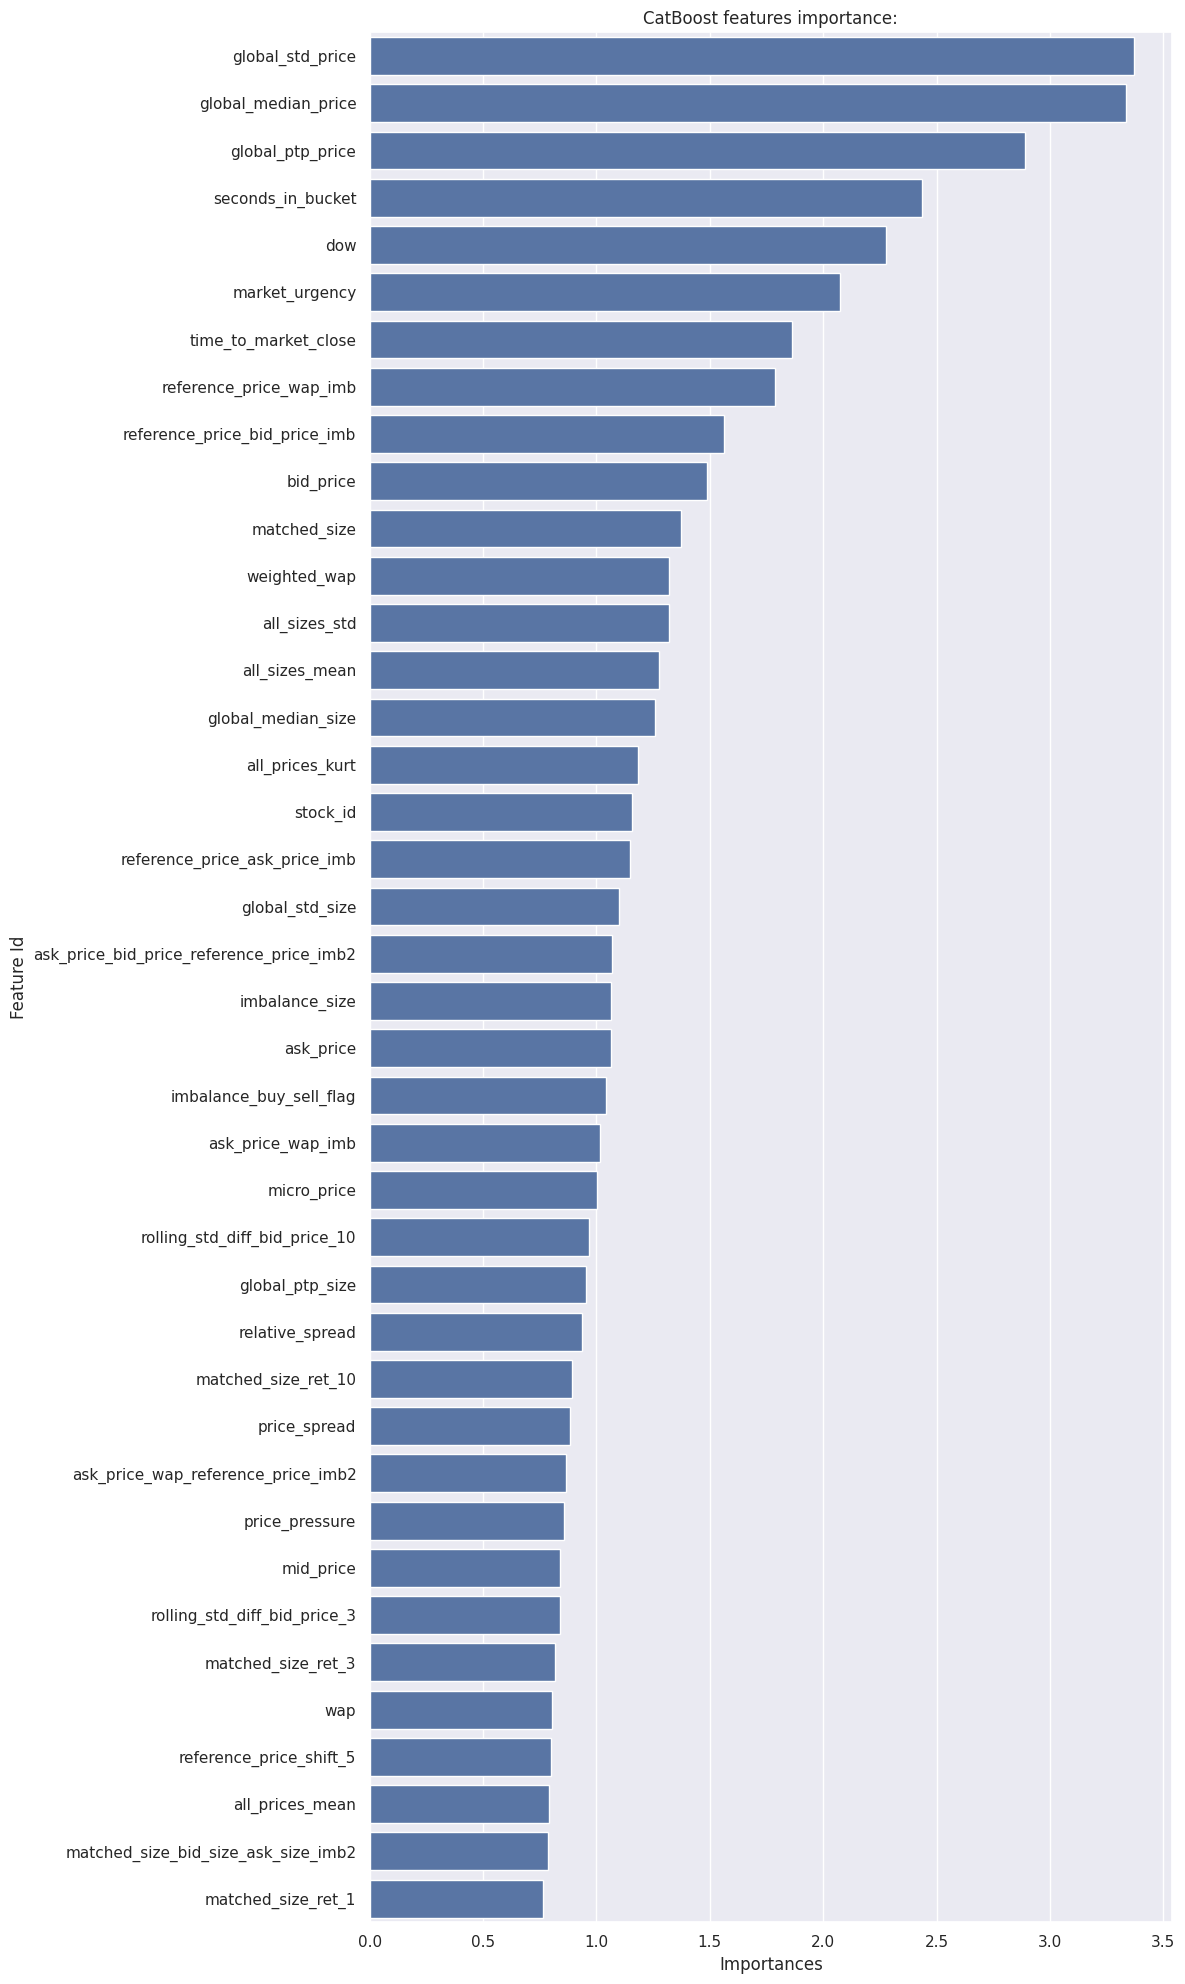

In [ ]:
feat_importances = model.get_feature_importance(prettified=True).head(40)

plt.figure(figsize=(12, 20))
sns.barplot(x="Importances", y="Feature Id", data=feat_importances)
plt.title('CatBoost features importance:')
plt.tight_layout()

# 5. LGBM Model Training

In [ ]:
#LGBMRegressor mae
def objective(trial):
    params = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "n_estimators": trial.suggest_int('n_estimators', 20, 500),
        "objective": trial.suggest_categorical("objective",['mae']),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 1.0),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.5, 1, step=0.1),
        #"n_jobs":trial.suggest_int("n_jobs",[-1] ),
        "n_jobs":-1,
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
    }
    model = LGBMRegressor(**params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="mean_absolute_error")

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

In [ ]:
#sampler = TPESampler(seed=1)
#study = optuna.create_study(study_name="lightgbm", direction="minimize", sampler=sampler)
#study.optimize(objective, n_trials=200)

Best trial: {'num_leaves': 146, 'n_estimators': 494, 'objective': 'mae', 'learning_rate': 0.09675713378758799, 'max_depth': 13, 'min_child_samples': 38, 'subsample': 0.8846236833272005, 'colsample_bytree': 0.875635157953628, 'reg_alpha': 0.031598830941276745, 'reg_lambda': 0.26466457985079583, 'bagging_fraction': 1.0, 'bagging_freq': 8}

In [ ]:
# Lightgbm with OPTUNA tuned hyperparameters without undersampling

cv_predictions_lgbm = np.zeros(len(y_train))
test_predictions_lgbm = np.zeros(len(y_test))
#..................................................................................................................
feature_importance_lgbm=pd.DataFrame()
feature_importance_lgbm["features"]=X_train.columns.to_list()
feature_importance_lgbm["importance"]=0
#..................................................................................................................
models=dict()
#..................................................................................................................
i=1
skf = sk.model_selection.TimeSeriesSplit(5).split(X_train, y_train)
for fold, (train_index, test_index) in enumerate(skf):
    param_grid = {

        'num_leaves': 146,
        'n_estimators': 494,
        'objective': 'mae',
        'learning_rate': 0.09675713378758799,
        'max_depth': 13,
        'min_child_samples': 38,
        'subsample': 0.8846236833272005,
        'colsample_bytree': 0.875635157953628,
        'reg_alpha': 0.031598830941276745,
        'reg_lambda': 0.26466457985079583,
        'bagging_fraction': 1.0,
        'bagging_freq': 8
        }

    model = LGBMRegressor(**param_grid)
    model.fit(X_train.iloc[train_index], y_train.iloc[train_index],
              eval_set=[(X_train.iloc[train_index], y_train.iloc[train_index]), (X_train.iloc[test_index], y_train.iloc[test_index])],
              eval_metric=["mae", "r2"]
              )  # Set verbose to True if you want to see the log

    print("---------------------------------------------------------------------------------------------------")
    print("Model LGBM "+str(i)+" :",model)
    models["Model LGBM "+str(i)]=model
    print("---------------------------------------------------------------------------------------------------")

    cv_predictions_lgbm[test_index] = model.predict(X_train.iloc[test_index])
    test_predictions_lgbm += model.predict(X_test)/5

    feature_importance_lgbm["importance"]+=model.feature_importances_ /5
    i+=1
#..............................................................................................................
# Calculate Mean Absolute Error (MAE) for the training and test sets
lgbm_mae_train = mean_absolute_error(y_train, cv_predictions_lgbm)
lgbm_mae_test = mean_absolute_error(y_test, test_predictions_lgbm)
#..............................................................................................................
print("LGBM's MAE CV Score:> ", round(lgbm_mae_train, 3))
print("LGBM's MAE Test Score:> ", round(lgbm_mae_test, 3))
print("-------------------------------------------------------------------------------------------------------")

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.8846236833272005 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.8846236833272005 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36443
[LightGBM] [Info] Number of data points in the train set: 26670, number of used features: 160
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.8846236833272005 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagg

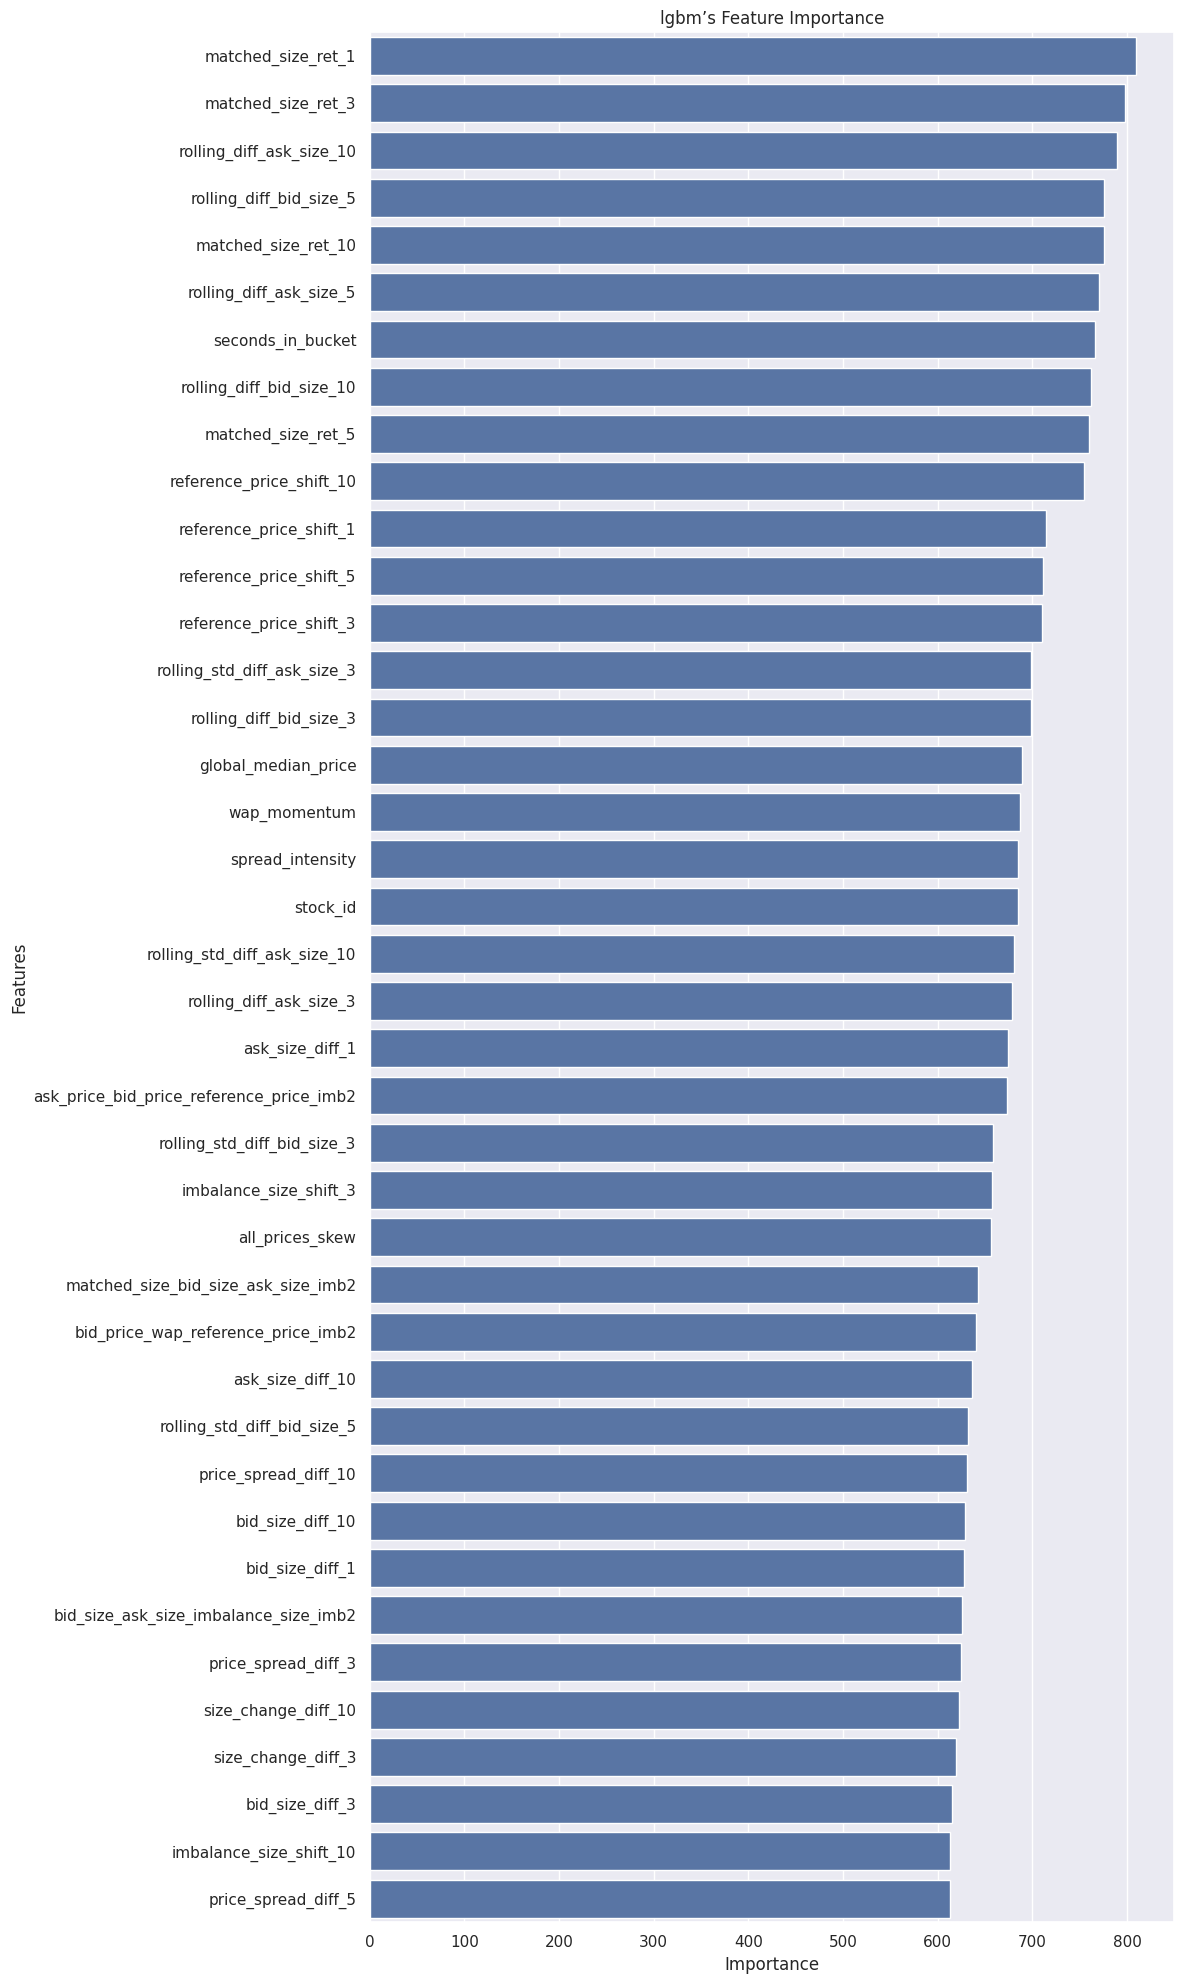

In [ ]:
plt.figure(figsize=(12, 20))
y=feature_importance_lgbm.sort_values(by="importance",ascending=False)["importance"][:40].values
x=[c for c in feature_importance_lgbm.sort_values(by="importance",ascending=False)["features"][:40].values]
sns.barplot(x=y,y=x)
plt.title("lgbm’s Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()

In [ ]:
variance_test = np.var(y_test)
min_test = min(y_test)
max_test = max(y_test)

results_df = pd.DataFrame({
    "Statistic": ["Variance", "Minimum", "Maximum"],
    "Value": [variance_test, min_test, max_test]
})
results_df

,Statistic,Value
0,Variance,59.796947
1,Minimum,-103.030205
2,Maximum,113.179688
